In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

#https://colab.research.google.com/github/JeroenMulkers/mumax3-tutorial/blob/master/postprocessing.ipynb#scrollTo=apKunwIp0s6_
def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays 
    with the ovffilename (without extension) as key"""
    
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    # convert all ovf files in the output directory to numpy files
    """p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))"""

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

runs={}
for pointiness in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    files=read_mumax3_ovffiles(f"pointinessData/pointiness-{pointiness}.out")
    snapshots=[files[fileName] for fileName in sorted(files.keys())]
    m = np.stack(snapshots)
    runs[pointiness]=m

dt=20e-12

KeyboardInterrupt: 

In [17]:
def getRunFFT(m):
    n=len(m)

    height=len(m[0][0][0])
    width=len(m[0][0][0][0])

    freqs=np.fft.fftfreq(n,dt)[:n//2]

    frequencies=np.zeros((height,width,len(freqs)),dtype=np.float64)
    for y in range(height):
        for x in range(width):
            if m[0,0,0,y,x]==0 and m[0,1,0,y,x]==0:
                continue
                pass
            xData=m[:,0,2,y,x]

            xFFT=np.fft.fft(xData)[:n//2]
            frequencies[y][x]=np.abs(xFFT)

    return freqs,frequencies

fftData={}
for name,m in runs.items():
    fftData[name]=getRunFFT(m)

C:\Users\Schif\AppData\Local\Temp\ipykernel_31628\2156894733.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(out)


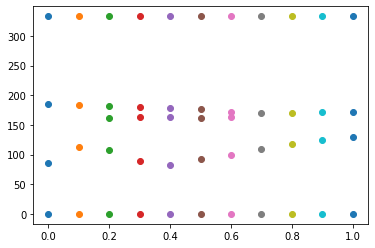

In [73]:
def runAnalysis(fftData,run):
    frequencies=fftData[1]
    freqs=fftData[0]

    peakFreqsI=np.argsort(-frequencies,axis=2)
    
    peakFreqs=freqs[peakFreqsI]
    print(peakFreqs)
    #plt.imshow(peakFreqs[:,:,0])


    uniquePeaksI=np.unique(peakFreqsI[:,:,0:5])
    print(freqs[uniquePeaksI])
    for i in uniquePeaksI:
        plt.imshow(np.abs(frequencies[:,:,i]),cmap="plasma")
        plt.title(f"X Oscillation amplitude at {round(freqs[i]*1e-9,2)}GHz")
        plt.colorbar()
        plt.show()

def getOverallFFT(fftData,run):
    frequencies=fftData[1]#[y,x,frequency]
    freqs=fftData[0]

    allFreqs=np.sum(np.sum(frequencies,axis=(0)),axis=0)
    return allFreqs


def getAdjacentRuns(arr):
    adjacent=False
    out=[]
    for el in arr:
        if len(out)==0 or out[-1][-1]!=el-1:
            out.append([el])
        else:
            out[-1].append(el)
    return np.array(out)

def getTopFrequencies(fftData,run):
    frequencies=fftData[1]
    freqs=fftData[0]

    peakFreqsI=np.argsort(-frequencies,axis=2)
    
    peakFreqs=freqs[peakFreqsI]
    #print(peakFreqs)
    #plt.imshow(peakFreqs[:,:,0])


    uniquePeaksI=np.unique(peakFreqsI[:,:,0:10])

    groups=getAdjacentRuns(uniquePeaksI)
    #print(groups)

    overallFFT=getOverallFFT(fftData,run)
    peaksI=[]
    for group in groups:
        overallVals=[overallFFT[i] for i in group]
        bestVal=group[np.argmax(overallVals)]
        peaksI.append(bestVal)
        #plt.scatter(group,group)
    
    
    #plt.scatter(peaksI,peaksI,c="k")
    #print(peaksI)
    return peaksI

    #plt.scatter(range(len(uniquePeaksI)),uniquePeaksI)

def plotFreq(fftData,run,freq):
    frequencies=fftData[1]
    freqs=fftData[0]

    plt.imshow(np.abs(frequencies[:,:,freq]),cmap="plasma")
    plt.title(f"X Oscillation amplitude at {round(freqs[freq]*1e-9,2)}GHz")
    plt.colorbar()
    plt.show()

#frequencyPlot(fftData[1],runs[1])
#runAnalysis(fftData[0.5],runs[0.5])
"""topFreqs=getTopFrequencies(fftData[0.5],runs[0.5])
for freq in topFreqs:
    plotFreq(fftData[0.5],runs[0.5],freq)"""

pointinesses=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
topFreqs=[]
for pointiness in pointinesses:
    topFreqs.append(getTopFrequencies(fftData[pointiness],runs[pointiness]))

for pointiness,freqs in zip(pointinesses,topFreqs):
    plt.scatter([pointiness]*len(freqs),freqs)
